In [1]:
import sys
sys.path.append('..')

from models import ForWard
from utils import to_dag

import networkx as nx
import pandas
from matplotlib import pyplot as plt
from tqdm import tqdm

import torch
from torch.nn import (
    BatchNorm2d,
    Conv2d,
    Flatten,
    Linear,
    LogSoftmax,
    MaxPool2d,
    NLLLoss,
    ReLU,
    Sequential
)
from torch.optim import SGD
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

/home/tommaso/miniconda3/envs/4ward/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
trainset = MNIST(
    root='../datasets',
    train=True,
    transform=ToTensor(),
    download=True
)
trainloader = DataLoader(
    dataset=trainset,
    batch_size=128,
    shuffle=True
)

testset = MNIST(
    root='../datasets',
    train=False,
    transform=ToTensor(),
    download=True
)
testloader = DataLoader(
    dataset=testset,
    batch_size=64
)

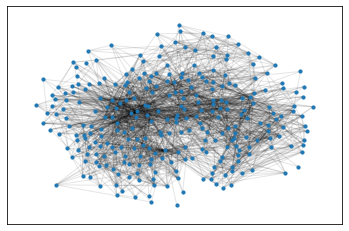

N: 281
L: 2402


In [7]:
# load the C. elegans connectome from the Excel sheet
# https://www.wormatlas.org/neuronalwiring.html#NeuronalconnectivityII
df = pandas.read_excel('NeuronConnect.xls')

# build the network edge list
edjlst = []
for line in df.values:
    edjlst.append(line[0] + ' ' + line[1])

# build the graph
G = nx.parse_edgelist(edjlst)

# extract the largest connected component
largest_cc = max(nx.connected_components(G), key=len)
G = G.subgraph(largest_cc).copy()

# convert to a DAG
dag = to_dag(G, seed=1)

def show_graph(G: nx.Graph):
    """TODO: add documentation
    """

    node_size = 10
    
    G = G.to_undirected()
    pos = nx.kamada_kawai_layout(G)
    
    nx.draw_networkx_nodes(G, pos, node_size=node_size)
    nx.draw_networkx_edges(G, pos, node_size=node_size, alpha=0.1)
    plt.show()

show_graph(dag)
print('N:', dag.number_of_nodes())
print('L:', dag.number_of_edges())

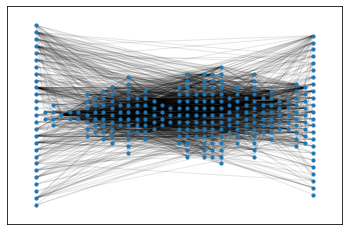

# of input features: 27
# of output features: 24


In [9]:
# transform the DAG into a feedforward NN
ffnn = ForWard(dag)

def show_layered_graph(G: nx.Graph, L: list):
    """TODO: add documentation
    """

    node_size = 10

    G = G.to_undirected()
    for l, nodes in enumerate(L):
        for v in nodes:
            G.nodes[v]['subset'] = l
    pos = nx.multipartite_layout(G)

    nx.draw_networkx_nodes(G, pos, node_size=node_size)
    nx.draw_networkx_edges(G, pos, node_size=node_size, alpha=0.1)
    plt.show()

show_layered_graph(ffnn.dag, ffnn.L)
print('# of input features:', ffnn.in_features)
print('# of output features:', ffnn.out_features)

In [11]:
device = torch.device('cuda:0')

model = Sequential(
    # convolutional feature extractor
    Conv2d(1, 64, kernel_size=3, padding=1),
    BatchNorm2d(64),
    ReLU(),
    MaxPool2d(kernel_size=2, stride=2),
    Conv2d(64, 128, kernel_size=3, padding=1),
    BatchNorm2d(128),
    ReLU(),
    MaxPool2d(kernel_size=2, stride=2),

    # interface
    Flatten(- 3, - 1),
    Linear(128*7*7, ffnn.in_features),
    ReLU(),

    # C. elegans-inspired network
    ffnn,
    
    # classifier
    Linear(ffnn.out_features, len(trainset.classes)),
    LogSoftmax(dim=1)
)

_ = model.to(device)

In [12]:
criterion = NLLLoss()
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)

In [16]:
for epoch in range(10):
    running_loss = 0.
    correct = 0
    for inputs, labels in tqdm(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # forward, backward & optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        predicted = torch.argmax(outputs, dim=1)
        correct += (predicted == labels).sum().item()
    
    print('epoch: {}, accuracy: {:.2%}'.format(epoch, correct/len(trainset)))

100%|██████████| 469/469 [00:25<00:00, 18.52it/s]


epoch: 0, accuracy: 80.20%


100%|██████████| 469/469 [00:22<00:00, 20.94it/s]


epoch: 1, accuracy: 93.58%


100%|██████████| 469/469 [00:22<00:00, 20.83it/s]


epoch: 2, accuracy: 95.56%


100%|██████████| 469/469 [00:22<00:00, 20.59it/s]


epoch: 3, accuracy: 96.70%


100%|██████████| 469/469 [00:22<00:00, 20.64it/s]


epoch: 4, accuracy: 97.31%


100%|██████████| 469/469 [00:22<00:00, 20.65it/s]


epoch: 5, accuracy: 97.83%


100%|██████████| 469/469 [00:24<00:00, 19.36it/s]


epoch: 6, accuracy: 98.11%


100%|██████████| 469/469 [00:22<00:00, 20.78it/s]


epoch: 7, accuracy: 98.32%


100%|██████████| 469/469 [00:22<00:00, 20.49it/s]


epoch: 8, accuracy: 98.50%


100%|██████████| 469/469 [00:23<00:00, 20.35it/s]

epoch: 9, accuracy: 98.69%


In [17]:
model.eval()

with torch.no_grad():
    correct = 0
    for inputs, labels in tqdm(testloader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # forward
        outputs = model(inputs)

        predicted = torch.argmax(outputs, dim=1)
        correct += (predicted == labels).sum().item()
    
print('accuracy: {:.2%}'.format(correct/len(testset)))

100%|██████████| 157/157 [00:02<00:00, 63.28it/s]

accuracy: 98.14%
